In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
pip install pymc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 11.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19/19 [pymc]38;5;237m━━ 18/19 [pymc]sor]
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pymc as pm

In [5]:
np.__version__

'2.3.4'

In [6]:
pm.__version__

'5.26.1'

In [7]:
df = pd.read_csv("cleaned_data.csv")

/var/folders/53/7nx8qd2s7vj41wbfr4t_fl700000gn/T/ipykernel_32143/1989269044.py:1: DtypeWarning: Columns (988,1170,1351,1365,1379,1393,1407,1412,1413,1436,1441,1442,1445,1446,1447,1450,1453,1454,1455,1456,1459,1460,1462,1473,1474,1475,1476,1487,1488,1489,1490,1491,1492,1497,1498,1501,1502,1503,1505,1508,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1525,1526,1527,1528,1529,1530,1532,1534,1535,1545,1548,1549,1550,1552,1555,1556,1557,1558,1559,1560,1562,1563,1564,1566,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1580,1583,1584,1587,1588,1589,1592,1593,1594,1597,1598,1601,1602,1605,1609,1623,1624,1625,1638,1653,1664,1679,1690,1692,1695,1702,1708,1711,1725,1726,1727,1728,1815,1816,1818,1823,1824,1830,1831,1844,1845,1846,1879,1880,1881,1882,1883,1908,1909,1910,1911,1912,1913,1961,1962,1963,1964,1983,1984,2044,2045,2046,2047,2072,2073,2074,2075,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2100,2101,2102,2103,2108,2109,2110,2111,2160,2259,2

In [8]:
y = df["MD_EARN_WNE_P10"].values
X = df["SAT_AVG"].values
regions, region_index = np.unique(df["REGION_NAME"], return_inverse=True)
R = len(regions)
N= len(y)

In [9]:
#Standardize X
X = (X - np.mean(X))/np.std(X)

In [10]:
S = 100000
alpha = 0.1
beta = 0.1
mu = 0.5
tau = 0.1
sigma = 0.05

In [11]:
b_samples = np.zeros((S))
a_samples = np.zeros((S,R))
m_samples = np.zeros((S))
t_samples = np.zeros((S))
s_samples = np.zeros((S))

In [12]:
a_val = np.zeros(R)
b_val = 0
m_val = 0
t_val = 1
s_val = 10

Log Functiosn

In [13]:
def log_likelihood(y, x, alpha, beta, sigma):
  mu = alpha[region_index] +(beta*x)
  return (-0.5*np.sum(np.log(2*np.pi*sigma**2) + ((y - mu)**2)/(sigma**2)))

In [14]:
def log_prior(beta, alpha, mu_alpha, tau_alpha, sigma):
  #Cauchhy distribution
  lp_beta = np.log(1/(np.pi*5*(1+(beta/5)**2)))
  #Notmal distribution
  lp_alpha = -0.5*np.sum((alpha-mu_alpha)**2 / tau_alpha**2) - (R*np.log(tau_alpha))
  #Normal
  lp_mu_alpha = -0.5*(mu_alpha**2/(50**2))
  #Half cauchy
  if tau_alpha <= 0:
    lp_tau_alpha = -np.inf
  else:
    lp_tau_alpha = np.log(2/np.pi)+np.log(5)-np.log((5**2) + tau_alpha**2)

  #half cauchy
  if sigma <= 0:
    lp_sigma = -np.inf
  else:
    lp_sigma = np.log(2/np.pi) +np.log(5)-np.log((5**2)+(sigma**2))

  return lp_beta + lp_alpha + lp_mu_alpha + lp_tau_alpha + lp_sigma


In [15]:
def log_post(y, x, alpha, beta, mu_alpha, tau_alpha, sigma):
  return log_likelihood(y,x,alpha, beta, sigma) + log_prior(beta, alpha, mu_alpha, tau_alpha, sigma)

Sampling

In [16]:
for s in range(S):
  #sample beta
  b_prop = b_val + np.random.normal(0, beta)
  logA = log_post(y,X,a_val, b_prop, m_val, t_val, s_val) - log_post(y, X, a_val, b_val, m_val, t_val, s_val)
  if np.log(np.random.rand()) < logA:
    b_val = b_prop
  b_samples[s] = b_val

  #sample alpha
  for r in range(R):
    a_prop = a_val.copy()
    a_prop[r] += np.random.normal(0, alpha)
    logA = log_post(y,X,a_prop, b_val, m_val, t_val,s_val) - log_post(y, X, a_val, b_val, m_val, t_val, s_val)
    if np.log(np.random.rand()) < logA:
      a_val[r] = a_prop[r]
  a_samples[s,:] = a_val

  #sample mu
  m_prop = m_val + np.random.normal(0, mu)
  logA = log_post(y,X,a_val, b_val, m_prop, t_val,s_val) - log_post(y, X, a_val, b_val, m_val, t_val, s_val)
  if np.log(np.random.rand()) < logA:
    m_val = m_prop
  m_samples[s] = m_val
  #sample tau
  t_prop = np.abs(t_val+np.random.normal(0, tau))
  logA = log_post(y,X,a_val, b_val, m_val, t_prop,s_val) - log_post(y, X, a_val, b_val, m_val, t_val, s_val)
  if np.log(np.random.rand()) < logA:
    t_val = t_prop
  t_samples[s] = t_val

  #sample sigma
  s_prop = np.exp(np.log(s_val) + np.random.normal(0, sigma))
  logA = log_post(y,X,a_val, b_val, m_val, t_val,s_prop) - log_post(y, X, a_val, b_val, m_val, t_val, s_val)
  if np.log(np.random.rand()) < logA:
    s_val = s_prop
  s_samples[s] = s_val

Visualization

In [17]:
def visualize_outcome(samples, param_name, burn_in=10000):
    samples_post = samples[burn_in:]
    print(param_name)
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.plot(samples_post)
    plt.xlabel("Iteration")
    plt.ylabel(param_name)
    plt.title("Trace Plot")
    
    plt.subplot(1,3,2)
    sns.histplot(samples_post, kde=True, bins=50)
    plt.title("Posterior Distribution")
  
    plt.subplot(1,3,3)
    plot_acf(samples_post, lags=50, ax=plt.gca())
    
    plt.tight_layout()
    plt.show()

Beta


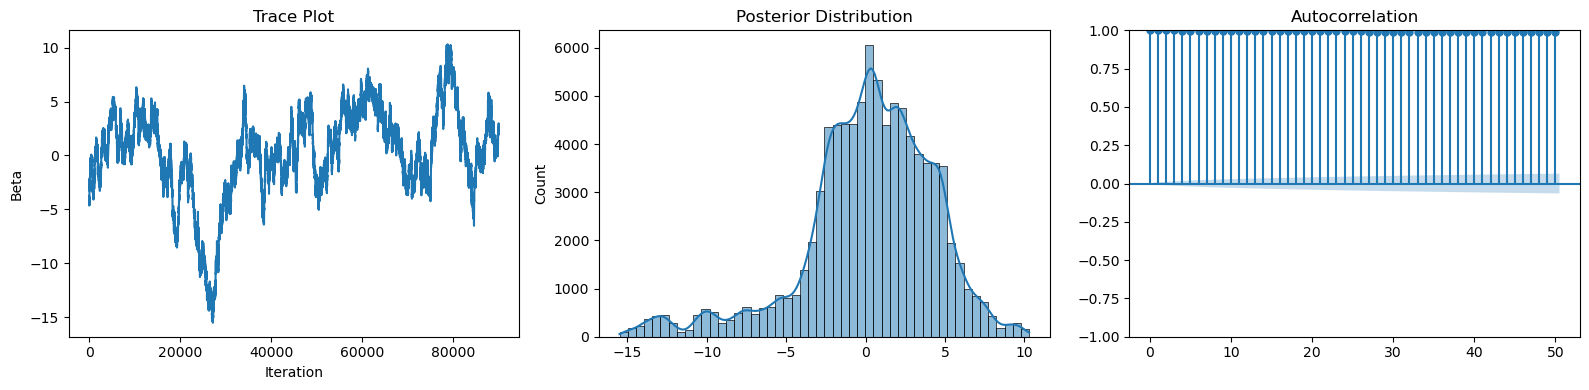

In [18]:
visualize_outcome(b_samples, "Beta")


Alpha - Region: Far West


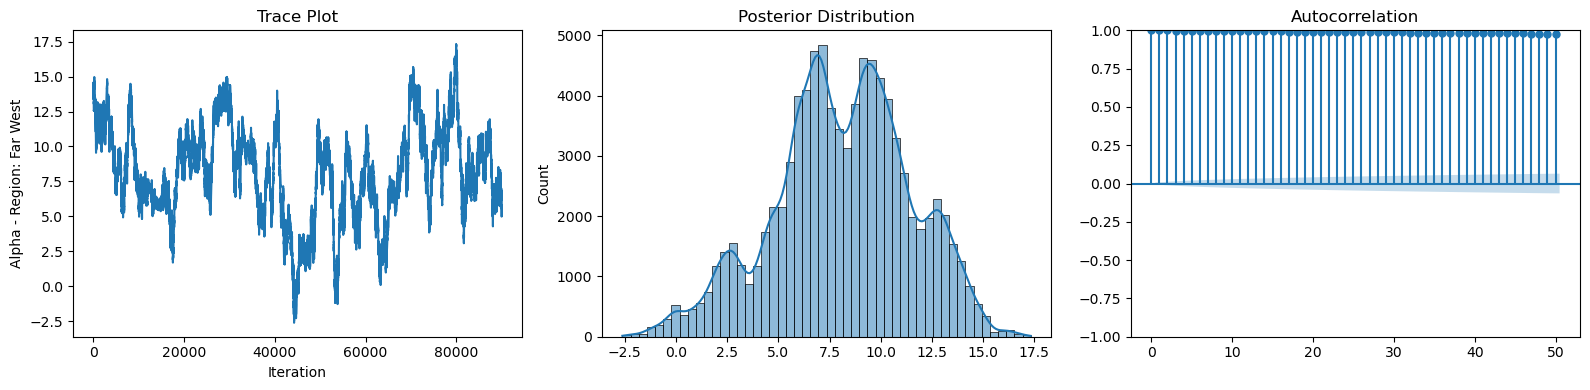

Alpha - Region: Great Lakes


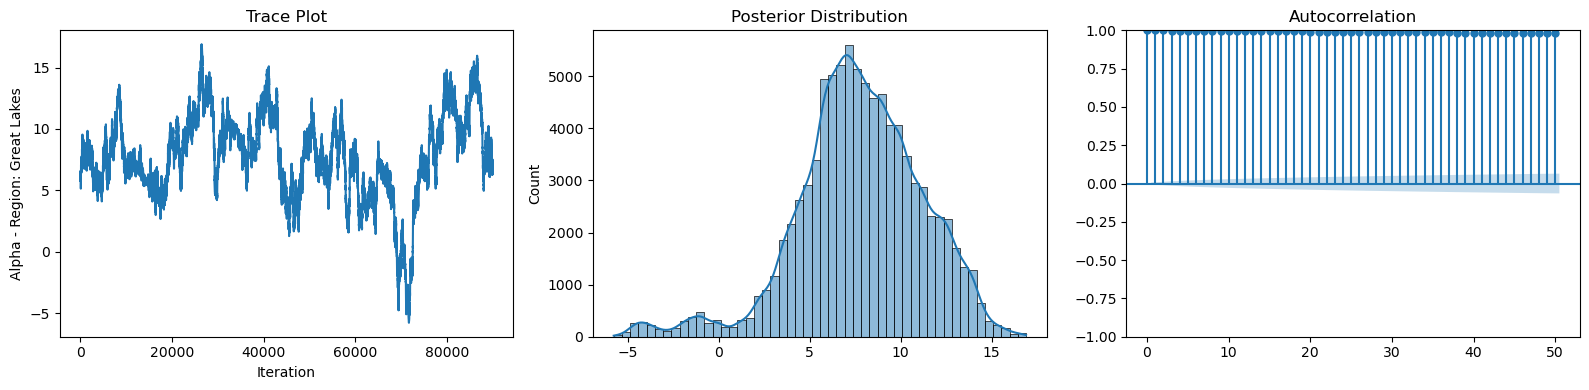

Alpha - Region: Mid East


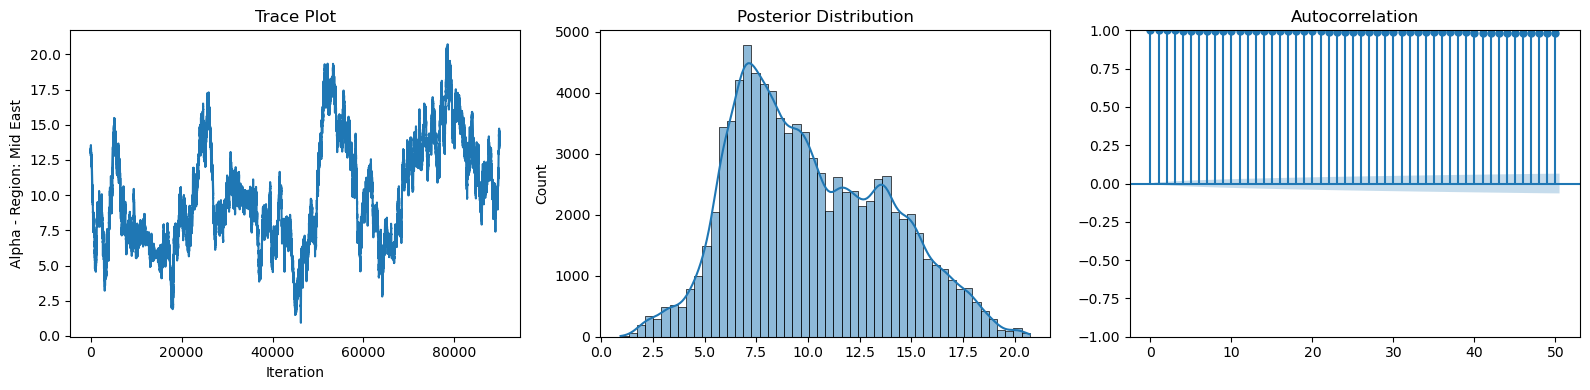

Alpha - Region: New England


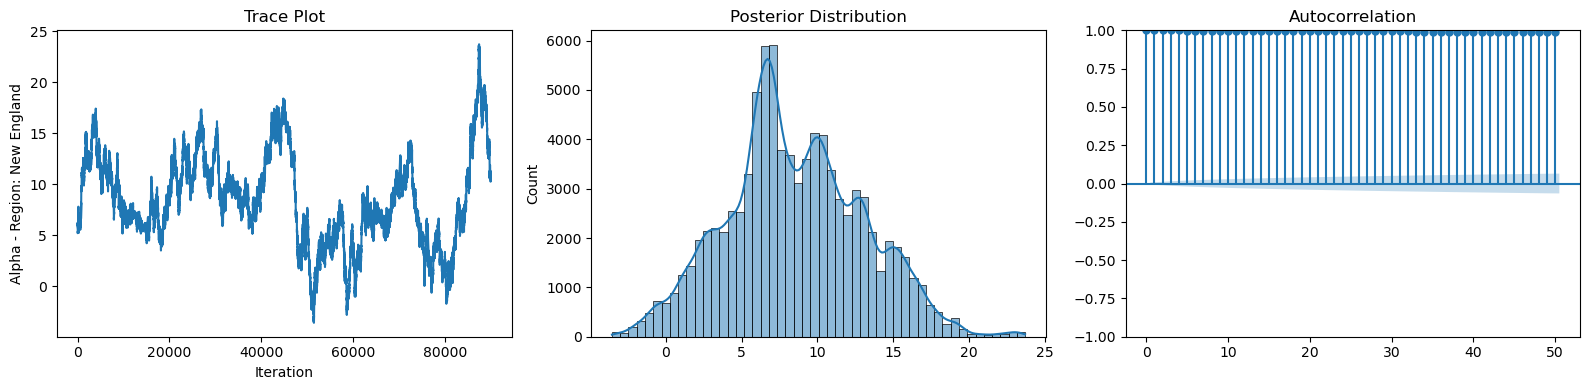

Alpha - Region: Outlying Areas


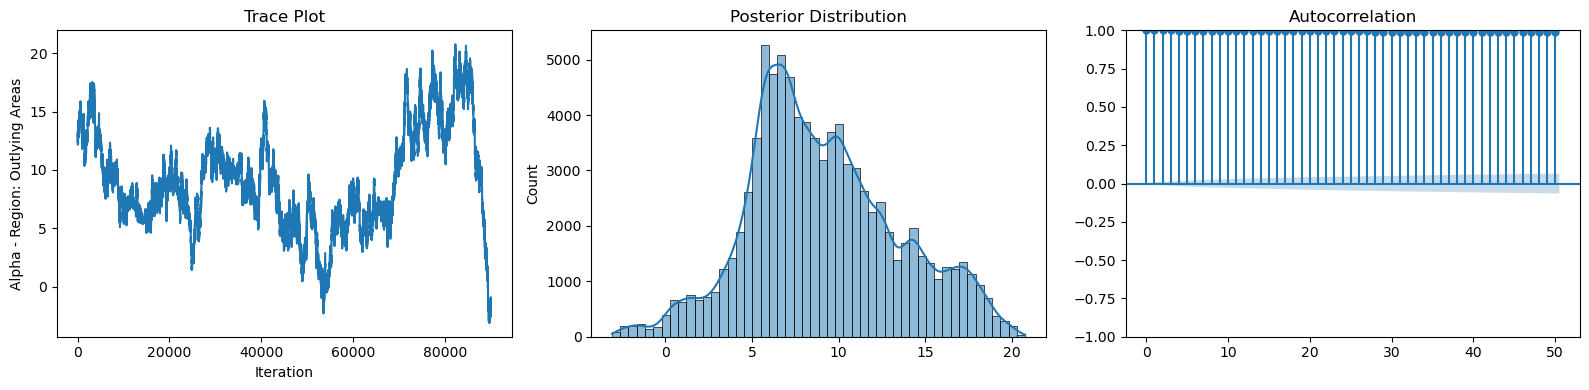

Alpha - Region: Plains


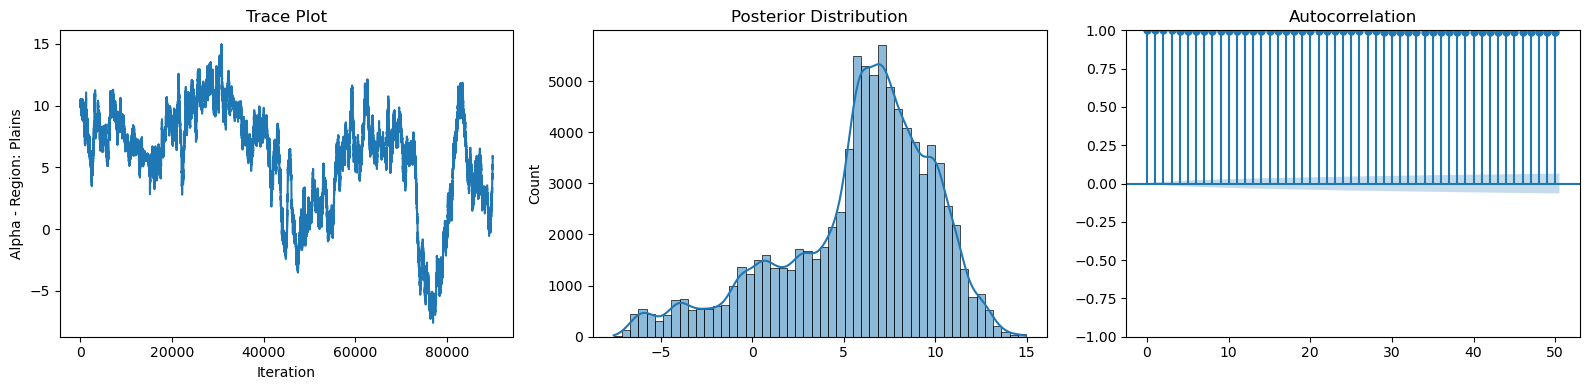

Alpha - Region: Rocky Mountains


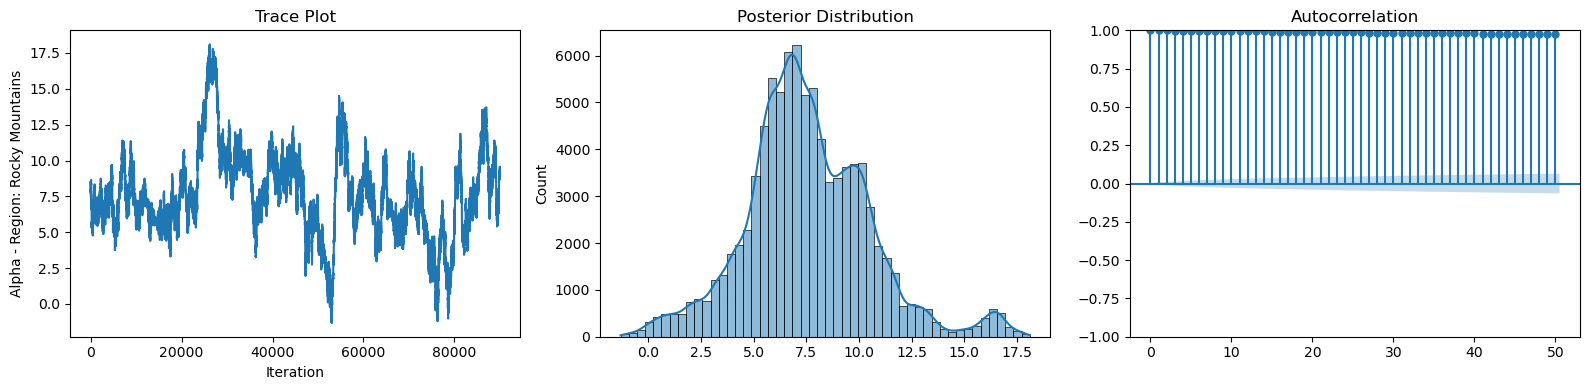

Alpha - Region: Southeast


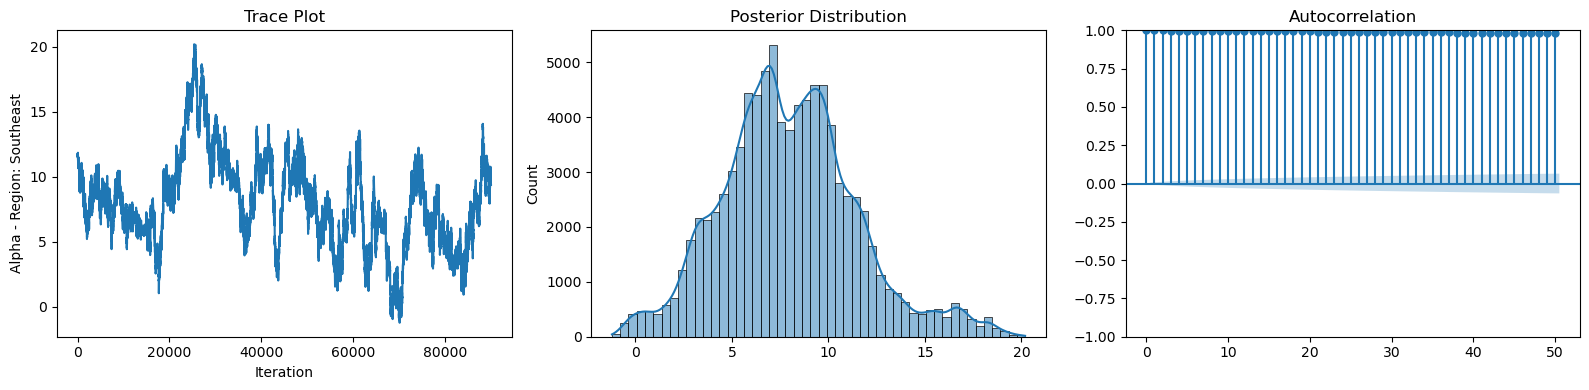

Alpha - Region: Southwest


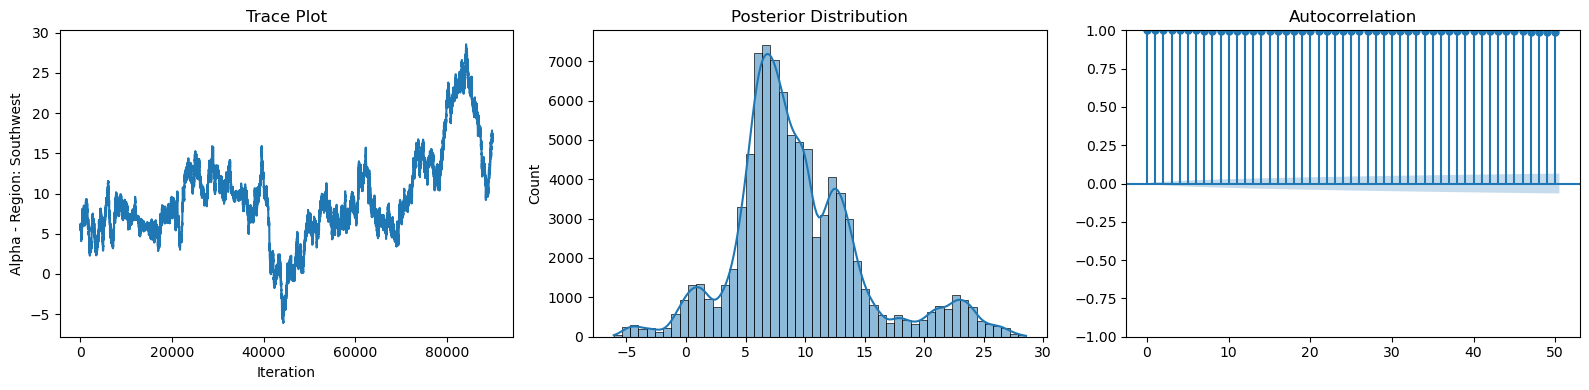

Alpha - Region: U.S. Service Schools


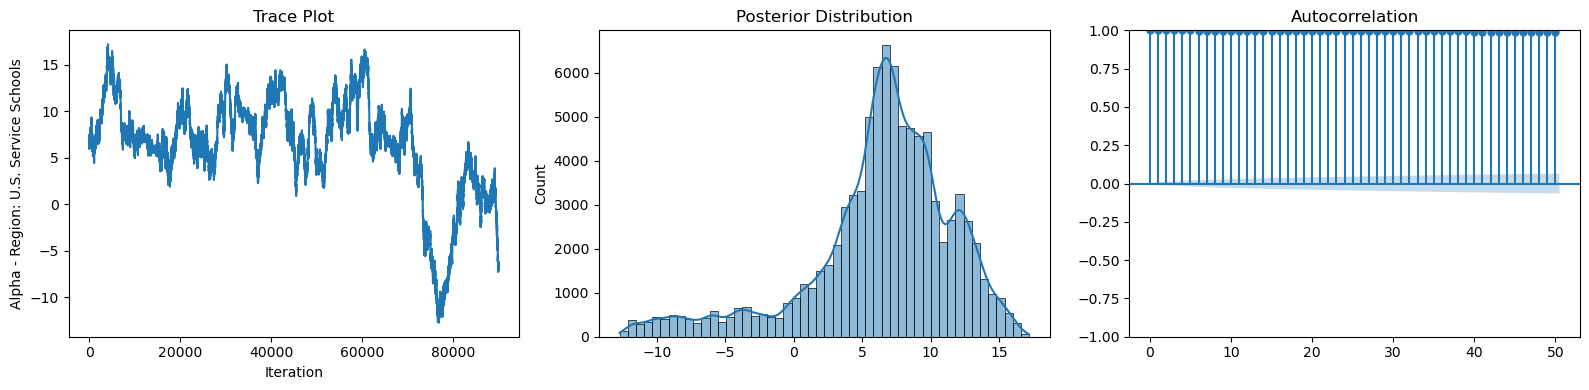

In [19]:
for r in range(R):
    visualize_outcome(a_samples[:,r], f"Alpha - Region: {regions[r]}")


Mu


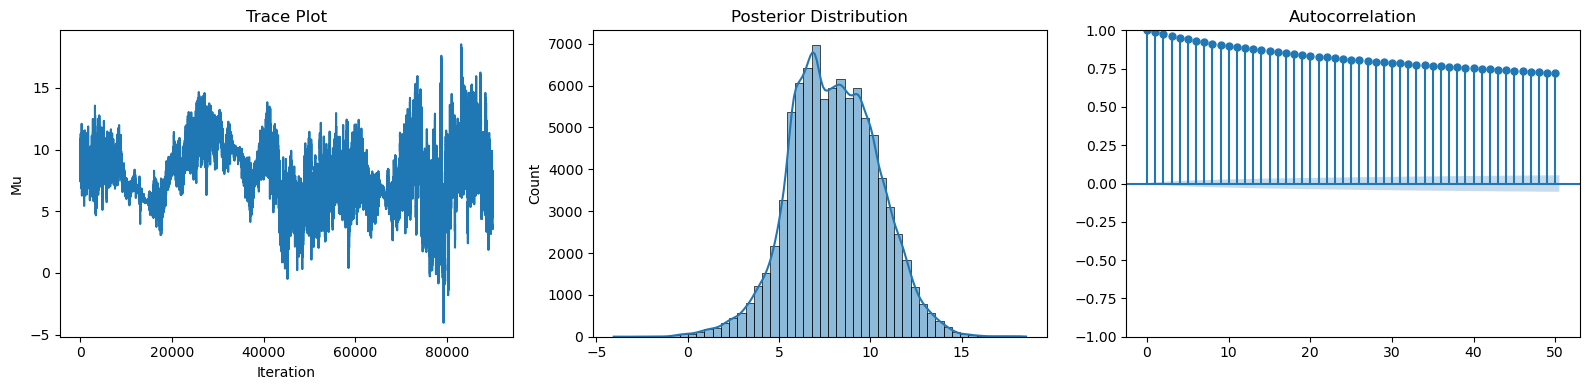

In [20]:
visualize_outcome(m_samples, "Mu")


Tau


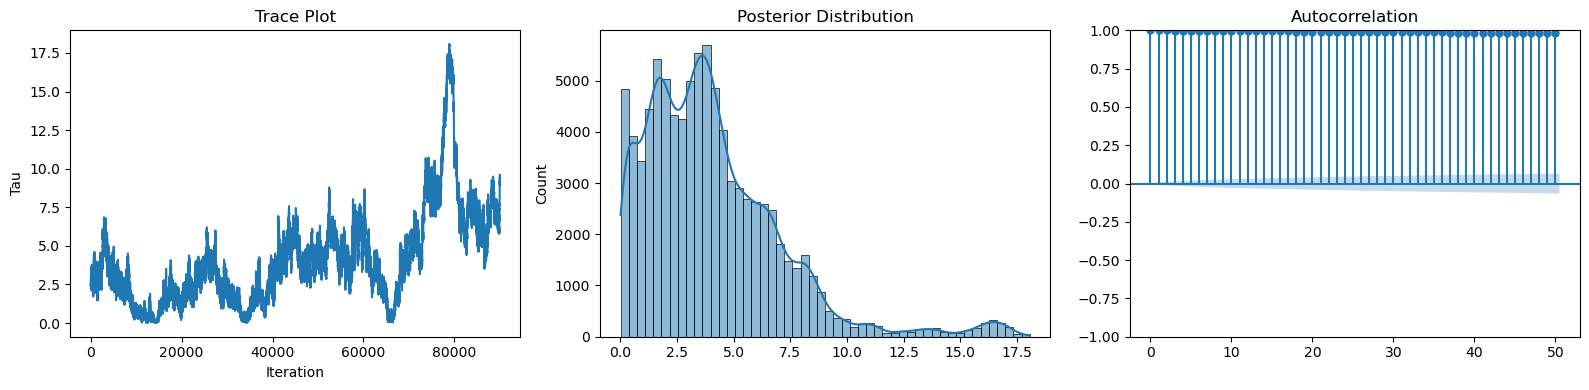

In [21]:
visualize_outcome(t_samples, "Tau")


Sigma


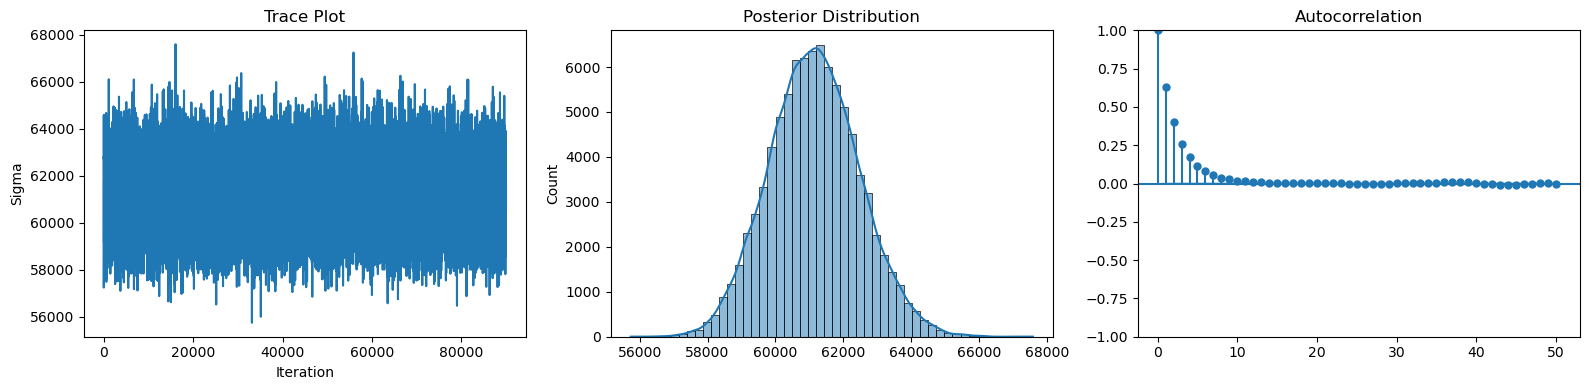

In [22]:
visualize_outcome(s_samples, "Sigma")


/var/folders/53/7nx8qd2s7vj41wbfr4t_fl700000gn/T/ipykernel_32143/237675182.py:4: DtypeWarning: Columns (988,1170,1351,1365,1379,1393,1407,1412,1413,1436,1441,1442,1445,1446,1447,1450,1453,1454,1455,1456,1459,1460,1462,1473,1474,1475,1476,1487,1488,1489,1490,1491,1492,1497,1498,1501,1502,1503,1505,1508,1511,1512,1513,1514,1515,1516,1517,1518,1519,1520,1521,1522,1525,1526,1527,1528,1529,1530,1532,1534,1535,1545,1548,1549,1550,1552,1555,1556,1557,1558,1559,1560,1562,1563,1564,1566,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1580,1583,1584,1587,1588,1589,1592,1593,1594,1597,1598,1601,1602,1605,1609,1623,1624,1625,1638,1653,1664,1679,1690,1692,1695,1702,1708,1711,1725,1726,1727,1728,1815,1816,1818,1823,1824,1830,1831,1844,1845,1846,1879,1880,1881,1882,1883,1908,1909,1910,1911,1912,1913,1961,1962,1963,1964,1983,1984,2044,2045,2046,2047,2072,2073,2074,2075,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2100,2101,2102,2103,2108,2109,2110,2111,2160,2259,22

/opt/miniconda3/envs/ml/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta       0.604  0.022   0.562    0.642      0.000    0.000  6211.980   
mu_alpha  -0.031  0.241  -0.475    0.437      0.006    0.004  1893.811   
tau_alpha  0.728  0.178   0.421    1.062      0.004    0.003  2485.933   
sigma      0.652  0.014   0.625    0.679      0.000    0.000  6794.249   

           ess_tail  r_hat  
beta       5194.517  1.001  
mu_alpha   2374.240  1.002  
tau_alpha  3423.547  1.002  
sigma      5043.728  1.001  
ESS (selected):
 <xarray.Dataset> Size: 352B
Dimensions:        (z_alpha_dim_0: 10, alpha_dim_0: 10)
Coordinates:
  * z_alpha_dim_0  (z_alpha_dim_0) int64 80B 0 1 2 3 4 5 6 7 8 9
  * alpha_dim_0    (alpha_dim_0) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    mu_alpha       float64 8B 1.894e+03
    z_alpha        (z_alpha_dim_0) float64 80B 2.072e+03 1.94e+03 ... 5.81e+03
    beta           float64 8B 6.212e+03
    tau_alpha      float64 8B 2.486e+03
    sigma          float64 

Sampling: [y_obs]


/opt/miniconda3/envs/ml/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

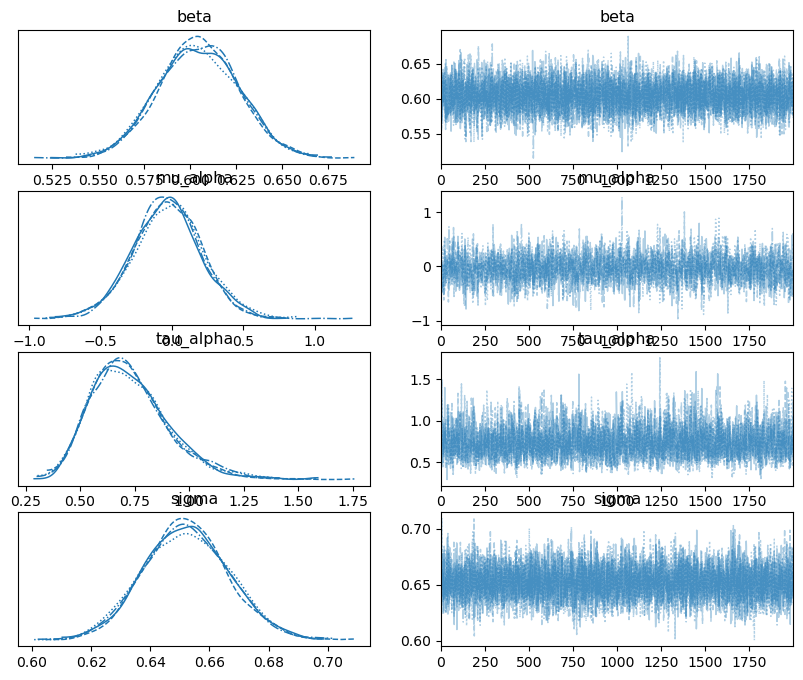

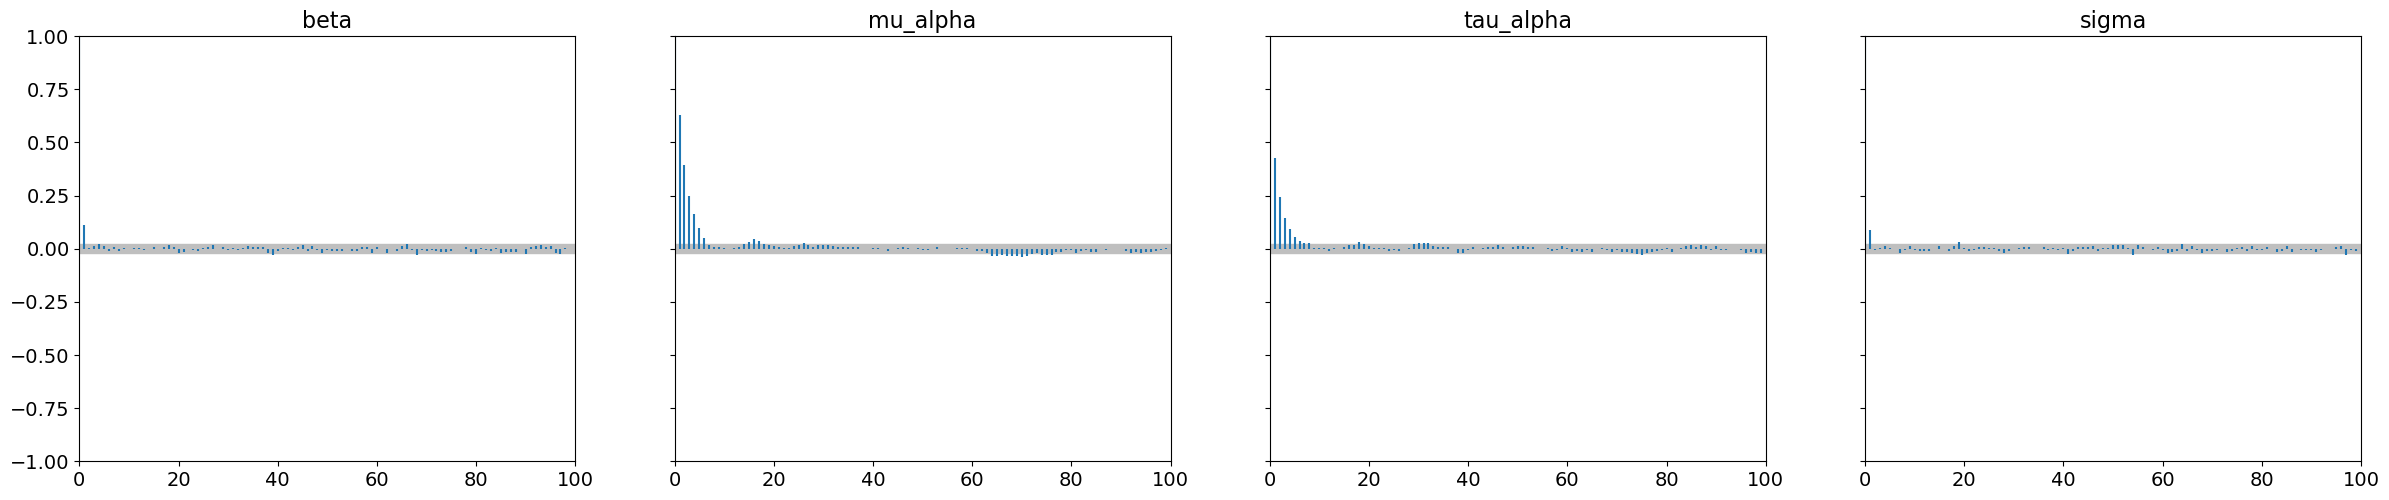

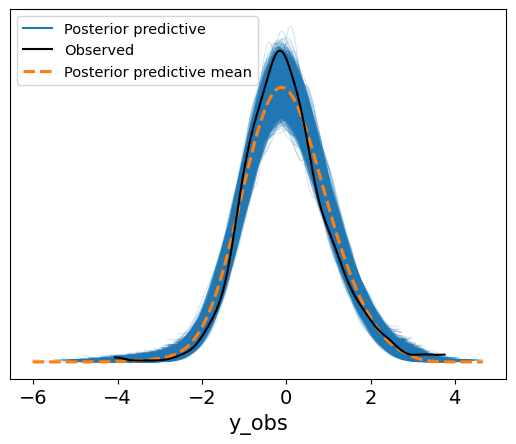

In [23]:

import pymc as pm
import arviz as az

df = pd.read_csv("cleaned_data.csv")

y_raw = df["MD_EARN_WNE_P10"].values
X = df["SAT_AVG"].values
regions, region_index = np.unique(df["REGION_NAME"], return_inverse=True)
R = len(regions)
N = len(y_raw)

y = np.log1p(y_raw)

y = (y - y.mean()) / y.std()

X = (X - X.mean()) / X.std()

#pymc hierarchical model (non-centered)
with pm.Model() as model:
    mu_alpha = pm.Normal("mu_alpha", mu=0.0, sigma=1.0)
    tau_alpha = pm.HalfNormal("tau_alpha", sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=0.5)

    z_alpha = pm.Normal("z_alpha", mu=0.0, sigma=1.0, shape=R)
    alpha = pm.Deterministic("alpha", mu_alpha + tau_alpha * z_alpha)


    beta = pm.Normal("beta", mu=0.0, sigma=0.5)

    mu = alpha[region_index] + beta*X
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    idata = pm.sample(
        draws=2000,       
        tune=2000,         
        chains=4,
        cores=4,
        target_accept=0.9, 
        return_inferencedata=True,
        random_seed=42
    )


print(az.summary(idata, var_names=["beta","mu_alpha","tau_alpha","sigma"], round_to=3))

ess = az.ess(idata)
print("ESS (selected):\n", ess)

az.plot_trace(idata, var_names=["beta","mu_alpha","tau_alpha","sigma"], figsize=(10,8))


az.plot_autocorr(idata, var_names=["beta","mu_alpha","tau_alpha","sigma"], combined=True)


ppc = pm.sample_posterior_predictive(
    idata, 
    var_names=["y_obs"],
    random_seed=42,
    model=model
)


az.plot_ppc(ppc, group="posterior")

beta_samples = idata.posterior["beta"].stack(sample=("chain","draw")).values
alpha_samples = idata.posterior["alpha"].stack(sample=("chain","draw")).values  

In [24]:
az.summary(idata, var_names=["beta", "sigma"])["r_hat"]

beta     1.0
sigma    1.0
Name: r_hat, dtype: float64

In [25]:
az.summary(idata, var_names=["beta"])["ess_bulk"]

beta    6212.0
Name: ess_bulk, dtype: float64

array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>,
       <Axes: title={'center': 'beta\n2'}>,
       <Axes: title={'center': 'beta\n3'}>], dtype=object)

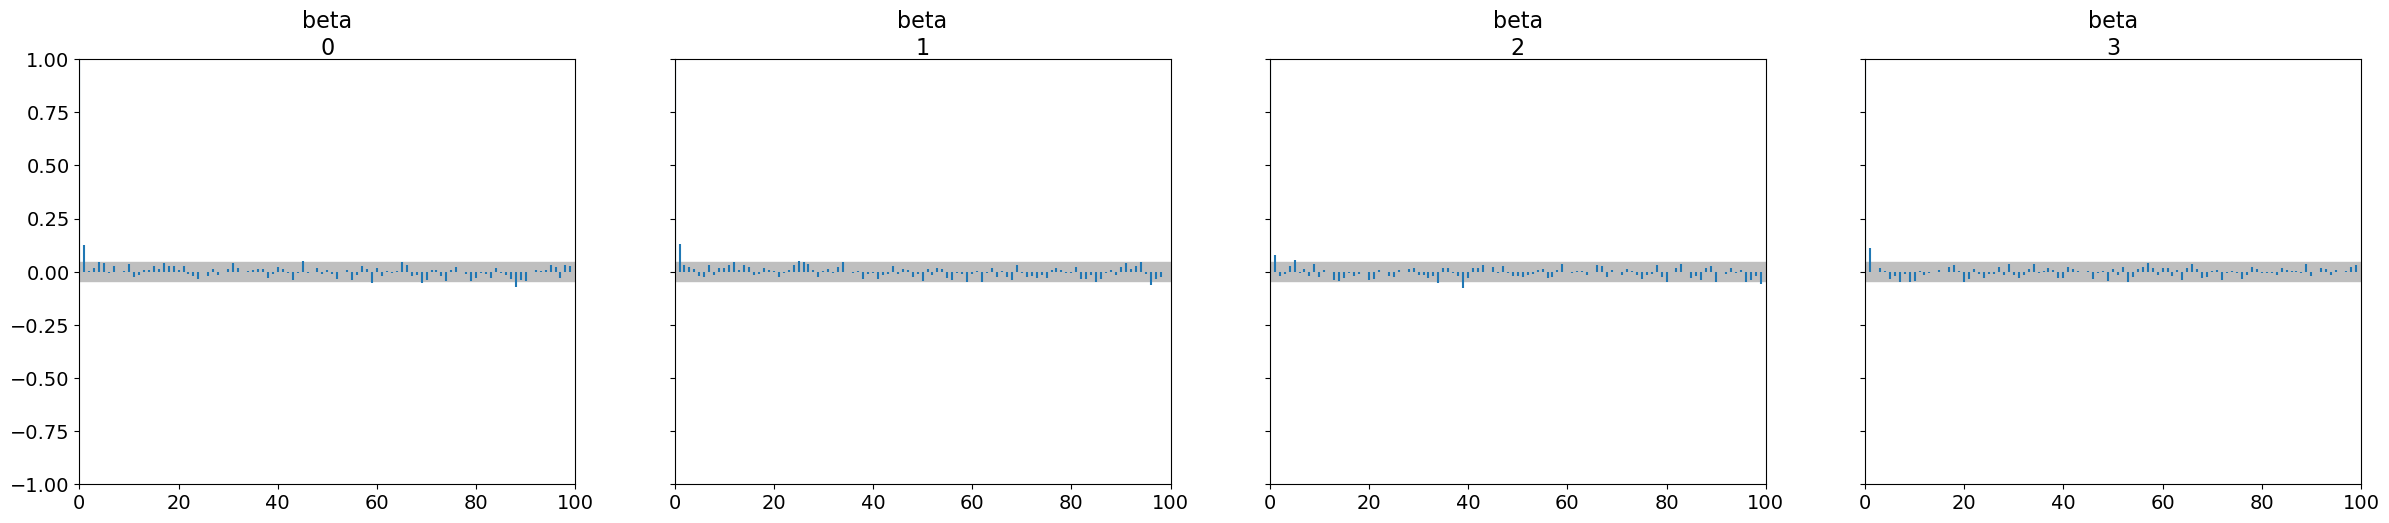

In [26]:
az.plot_autocorr(idata, var_names=["beta"])

In [27]:
from patsy import dmatrix

K = 5

B_df = dmatrix("bs(x, df={}, degree=3, include_intercept=False) - 1".format(K), {"x": X}, return_type="dataframe")

B = np.asarray(B_df)

print(B.shape)

(1060, 5)


In [28]:
R = len(regions)
N = len(y)

with pm.Model() as spline_model:

    mu_a = pm.Normal("mu_alpha", mu=0.0, sigma=1.0)        
    tau_a = pm.HalfNormal("tau_alpha", sigma=0.5)          
    z_a = pm.Normal("z_alpha", 0.0, 1.0, shape=R)          
    alpha = pm.Deterministic("alpha", mu_a + tau_a * z_a)  

    tau_g = pm.HalfNormal("tau_gamma", sigma=0.5)         
    gamma = pm.Normal("gamma", mu=0.0, sigma=tau_g, shape=B.shape[1])


    sigma = pm.HalfNormal("sigma", sigma=0.5)

    mu = alpha[region_index] + pm.math.dot(B, gamma)

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    idata = pm.sample(draws=2000, tune=2000, chains=4, target_accept=0.9, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, tau_alpha, z_alpha, tau_gamma, gamma, sigma]
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


/opt/miniconda3/envs/ml/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha  -0.511  0.386  -1.282    0.172      0.008    0.005  2183.867   
tau_alpha  0.788  0.182   0.473    1.128      0.003    0.002  2730.403   
tau_gamma  1.111  0.234   0.701    1.562      0.003    0.003  5690.852   
sigma      0.644  0.014   0.618    0.671      0.000    0.000  8014.371   
gamma[0]  -0.399  0.440  -1.198    0.444      0.008    0.006  2723.899   
gamma[1]  -0.163  0.289  -0.691    0.394      0.005    0.004  2788.847   
gamma[2]   1.088  0.351   0.396    1.719      0.007    0.005  2710.777   
gamma[3]   1.196  0.331   0.600    1.831      0.006    0.004  3162.560   
gamma[4]   2.646  0.343   2.001    3.283      0.007    0.005  2733.360   

           ess_tail  r_hat  
mu_alpha   3129.723  1.001  
tau_alpha  4051.439  1.001  
tau_gamma  5138.441  1.000  
sigma      5225.849  1.000  
gamma[0]   3703.277  1.001  
gamma[1]   3965.509  1.002  
gamma[2]   3709.661  1.001  
gamma[3]   4360.368  1.002 

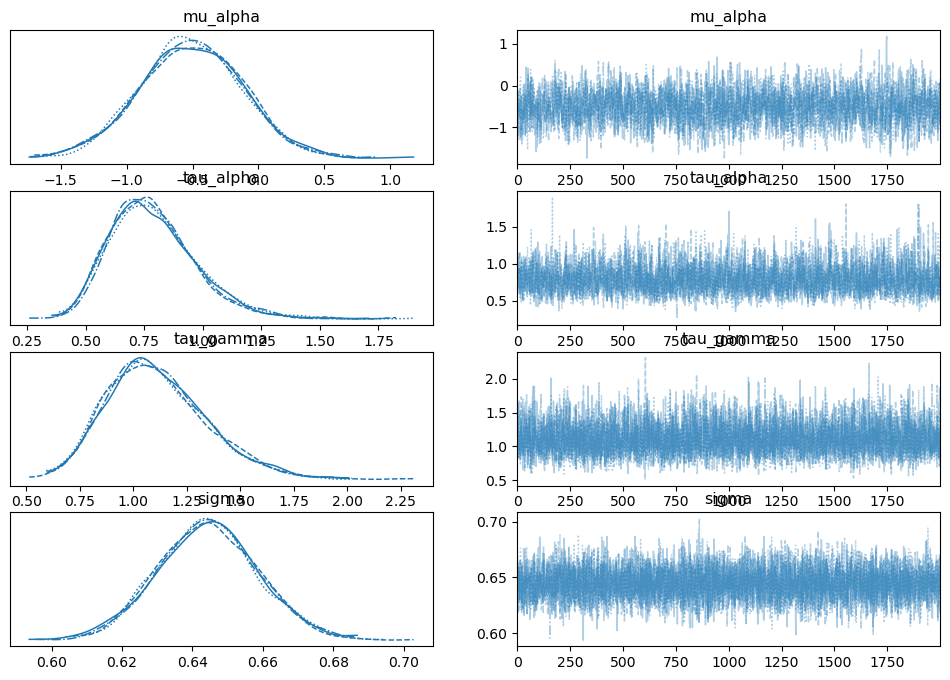

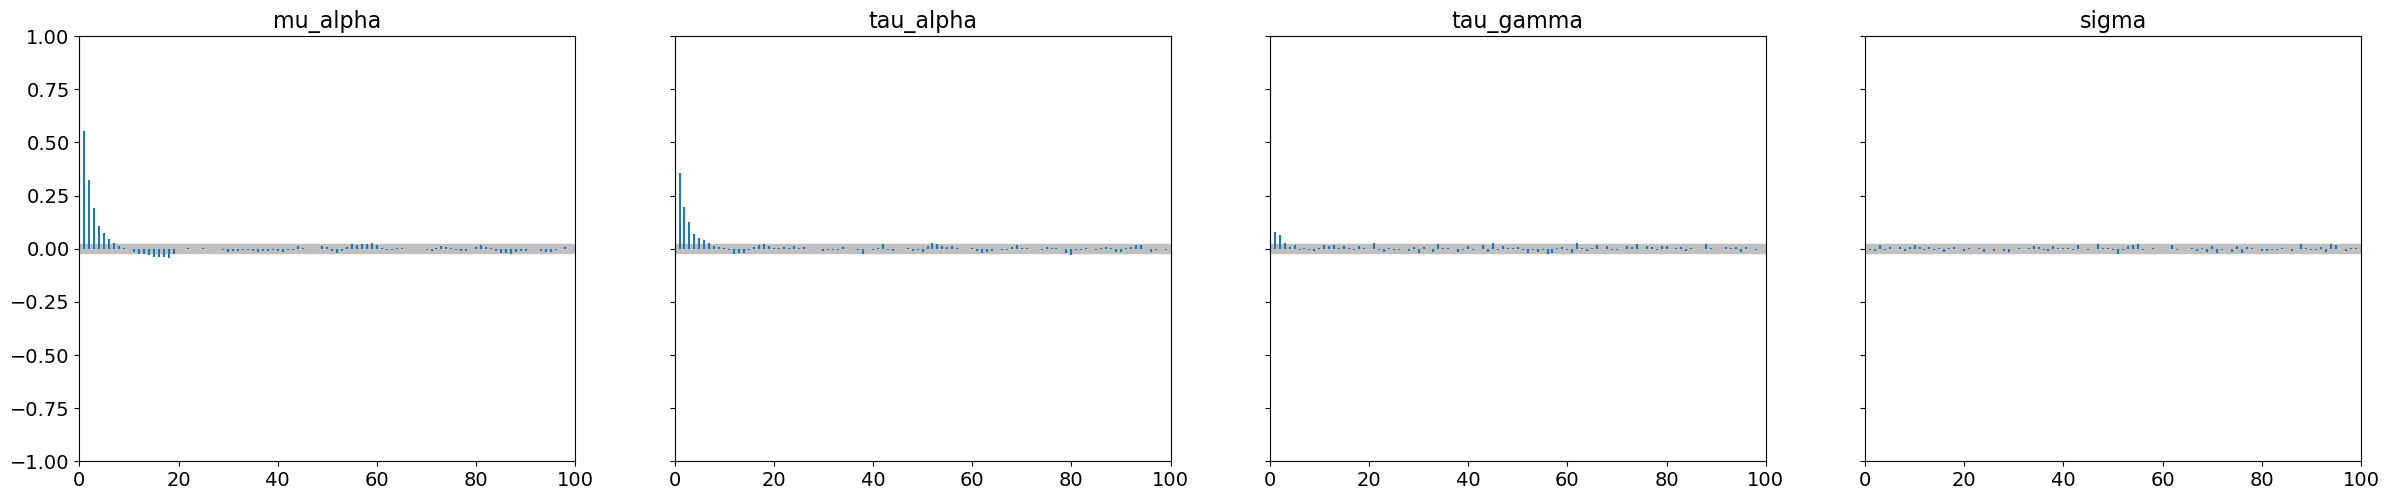

In [29]:
print(az.summary(idata, var_names=["mu_alpha","tau_alpha","tau_gamma","sigma","gamma"], round_to=3))

az.plot_trace(idata, var_names=["mu_alpha","tau_alpha","tau_gamma","sigma"], compact=True)
az.plot_autocorr(idata, var_names=["mu_alpha","tau_alpha","tau_gamma","sigma"], combined=True)

print("Any divergences:", idata.sample_stats["diverging"].any().item())
print(az.summary(idata, var_names=["mu_alpha","tau_alpha","tau_gamma","sigma"])[["r_hat","ess_bulk","ess_tail"]])

/var/folders/53/7nx8qd2s7vj41wbfr4t_fl700000gn/T/ipykernel_32143/2746879405.py:15: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  f_hdi = az.hdi(f_grid_draws.T, hdi_prob=0.95)  # returns (len(x_grid), 2)


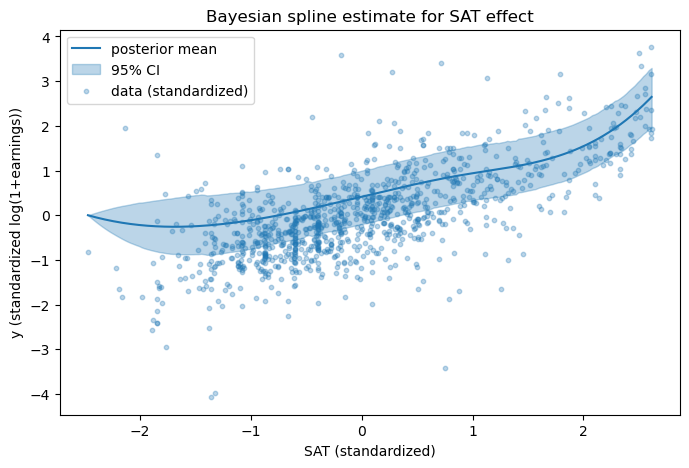

In [30]:
# grid on standardized x

x_grid = np.linspace(X.min(), X.max(), 200)

B_grid = np.asarray(dmatrix("bs(x, df={}, degree=3, include_intercept=False) - 1".format(K),{"x": x_grid}, return_type="dataframe"))

posterior = idata.posterior
gamma_samples = posterior["gamma"].stack(sample=("chain","draw")).values  
f_grid_draws = B_grid.dot(gamma_samples)   

f_mean = f_grid_draws.mean(axis=1)
f_hdi = az.hdi(f_grid_draws.T, hdi_prob=0.95)  

plt.figure(figsize=(8,5))
plt.plot(x_grid, f_mean, label="posterior mean")
plt.fill_between(x_grid, f_hdi[:,0], f_hdi[:,1], color="C0", alpha=0.3, label="95% CI")
plt.scatter(X, y, s=10, alpha=0.3, label="data (standardized)")
plt.xlabel("SAT (standardized)")
plt.ylabel("y (standardized log(1+earnings))")
plt.legend()
plt.title("Bayesian spline estimate for SAT effect")
plt.show()

Sampling: [y_obs]


/opt/miniconda3/envs/ml/lib/python3.11/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

<Axes: xlabel='y_obs'>

/opt/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/miniconda3/envs/ml/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


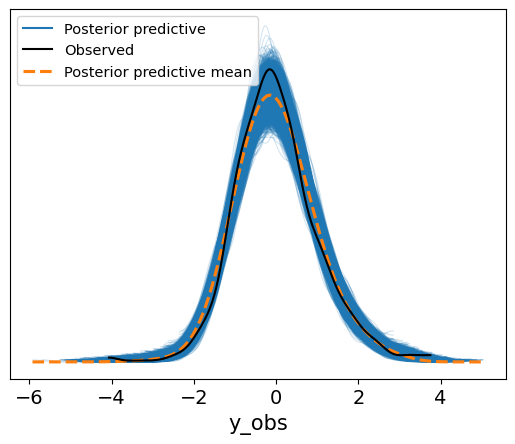

In [45]:
ppc = pm.sample_posterior_predictive(idata, var_names=["y_obs"], random_seed=42, model=spline_model)
az.plot_ppc(ppc, group="posterior")



/var/folders/53/7nx8qd2s7vj41wbfr4t_fl700000gn/T/ipykernel_32143/3702839158.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  deriv_hdi = az.hdi(deriv.T, hdi_prob=0.95)


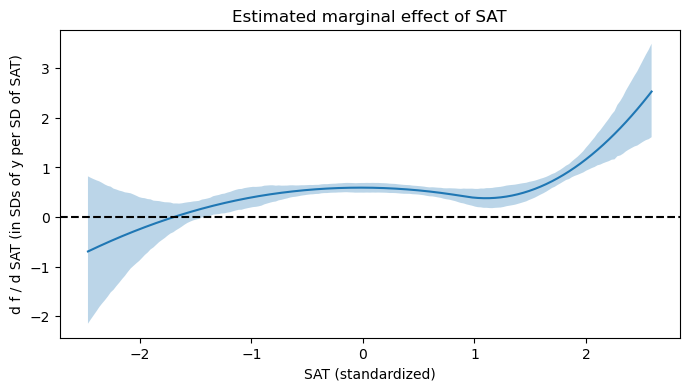

In [33]:
dx = x_grid[1]-x_grid[0]
f_plus = f_grid_draws[1:,:]
f_minus = f_grid_draws[:-1,:]
deriv = (f_plus - f_minus) / dx   

deriv_mean = deriv.mean(axis=1)
deriv_hdi = az.hdi(deriv.T, hdi_prob=0.95)

plt.figure(figsize=(8,4))
plt.plot(x_grid[:-1], deriv_mean, label="marginal effect (df/dx)")
plt.fill_between(x_grid[:-1], deriv_hdi[:,0], deriv_hdi[:,1], alpha=0.3)
plt.axhline(0, color="k", ls="--")
plt.xlabel("SAT (standardized)")
plt.ylabel("d f / d SAT (in SDs of y per SD of SAT)")
plt.title("Estimated marginal effect of SAT")
plt.show()

/var/folders/53/7nx8qd2s7vj41wbfr4t_fl700000gn/T/ipykernel_32143/3846098530.py:32: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  f_hdi_std = az.hdi(f_grid_draws_std.T, hdi_prob=0.95)


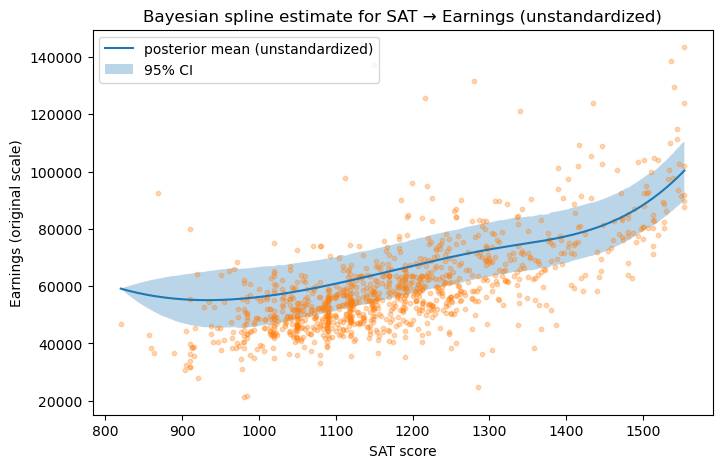

In [42]:
#unstandardized

X_original = df["SAT_AVG"].values
X_mean = X_original.mean()
X_std = X_original.std()

y_original = df["MD_EARN_WNE_P10"].values
y_mean = y_original.mean()
y_std = y_original.std()


x_grid_orig = np.linspace(X_original.min(), X_original.max(), 200)
x_grid_std = (x_grid_orig - X_mean) / X_std

B_grid = np.asarray(
    dmatrix(
        f"bs(x, df={K}, degree=3, include_intercept=False) - 1",
        {"x": x_grid_std},
        return_type="dataframe"
    )
)

posterior = idata.posterior


gamma_samples = posterior["gamma"].stack(sample=("chain","draw")).values
f_grid_draws_std = B_grid.dot(gamma_samples)

f_mean_unstd = f_grid_draws_std.mean(axis=1) * y_std + y_mean

f_hdi_std = az.hdi(f_grid_draws_std.T, hdi_prob=0.95)
f_hdi_unstd = f_hdi_std * y_std + y_mean

plt.figure(figsize=(8,5))
plt.plot(x_grid_orig, f_mean_unstd, label="posterior mean (unstandardized)")
plt.fill_between(x_grid_orig, f_hdi_unstd[:,0], f_hdi_unstd[:,1], alpha=0.3, label="95% CI")

plt.scatter(X_original, y_original, s=10, alpha=0.3)

plt.xlabel("SAT score")
plt.ylabel("Earnings (original scale)")
plt.title("Bayesian spline estimate for SAT → Earnings (unstandardized)")
plt.legend()
plt.show()